In [1]:
import matplotlib.pyplot as pt
import matplotlib.pyplot
import numpy as np
import cv2
import json

from pathlib import Path
import glob
import os
import torch

In [2]:
def show(*args, labels=[], show_axis=False, figsize=(10, 5), save_to: str = None):
    l = len(args)

    if len(labels) < l:
        labels += [None] * (l - len(labels))

    fg, plots = pt.subplots(int(l ** .5), l // int(l ** .5), figsize=figsize)

    try:
        plots = plots.flatten()
    except:
        plots = [plots]

    for m, p, l in zip(args, plots, labels):
        ax: matplotlib.image.AxesImage = p.imshow(m)

        if not show_axis:
            ax.axes.axis('off')

        if l:
            ax.axes.title.set_text(l)

    if save_to is not None:
        pt.savefig(save_to)

def drawbox(img, boxes, show_indices=False):
    img = img.copy()
    zoom = 1

    if show_indices:
        zoom = 3
        img = cv2.resize(img, np.array(img.shape[:2]) * zoom, interpolation=cv2.INTER_CUBIC)

    for i, box in enumerate(boxes):
        box = box.astype(int) * zoom
        cv2.rectangle(img, box[:2], box[2:], (255, 255, 0), 1)

        if show_indices:
            # x = int(box[[0, 2]].mean().item())
            x = int(box[0].item())
            y = int(box[[1, 3]].mean().item())

            cv2.putText(img, str(i), (x, y), cv2.FONT_HERSHEY_TRIPLEX, .3, (255, 255, 255), 1)

    return img

def fillbox(rimg, boxes, scores, dest=False):
    if not dest:
        rimg = rimg.copy()

    for box, score in sorted(zip(boxes, scores), key=lambda _: _[1], reverse=True):
        cv2.fillPoly(rimg, to_points(box.astype(int)).reshape(1, 4, 2), score, 1)

    return rimg

def readimg(path):
    img = cv2.imread(path)
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB, img)

    return img

def readjson(path):
    dt = json.load(open(path))

    return dt["box"]

def to_xywh(boxes):
    if boxes.ndim == 2:
        boxes = np.stack([boxes[:, 0], boxes[:, 1], boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]], axis=1)
        return boxes

    elif boxes.ndim == 1:
        return np.array([boxes[0], boxes[1], boxes[2] - boxes[0], boxes[3] - boxes[1]])

def to_points(boxes):
    if boxes.ndim == 2:
        boxes = np.stack([boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 1], boxes[:, 3], boxes[:, 0], boxes[:, 3]], axis=1)
        return boxes

    elif boxes.ndim == 1:
        return np.array([boxes[0], boxes[1], boxes[2], boxes[1], boxes[2], boxes[3], boxes[0], boxes[3]])


In [ ]:
data_root_dir = Path("/Users/shreyas/Developer/Research/GroundingDINO/data/satellite")

images_dir = data_root_dir / "images"
masks_dir = data_root_dir / "masks"
boxes_dir = data_root_dir / "boxes"

pdata = {}

for f in glob.glob(str(boxes_dir / "*.json")):
    fname = os.path.basename(f)
    iid, _ = os.path.splitext(fname)

    pdata[iid] = [str(images_dir / f"{iid}.tif"), f]

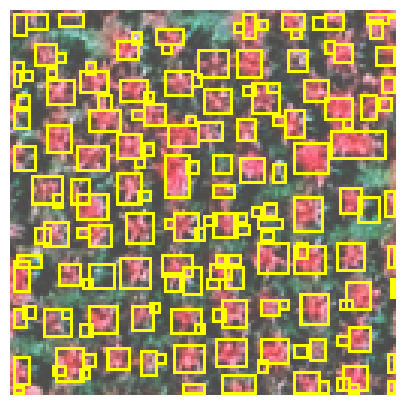

In [51]:
image_id = "high_density_coconut_9"
# image_id = "high_density_mango_77"
# image_id = "low_density_coconut_1"
# image_id = "medium_density_coconut_4"
# image_id = "high_density_mango_3"
# image_id = "high_density_mango_52"
# image_id = "high_density_coconut_52"

def filter_fn(box):
    w = box[:, 2] - box[:, 0]
    h = box[:, 3] - box[:, 1]

    th = 5

    return (w >= th) & (h >= th)

image_f, boxes_f = pdata[image_id]
image = readimg(image_f)
sboxes = np.array(readjson(boxes_f), dtype=float)
boxes = sboxes.copy()
# boxes = sboxes[filter_fn(sboxes)]

show(drawbox(image, sboxes))

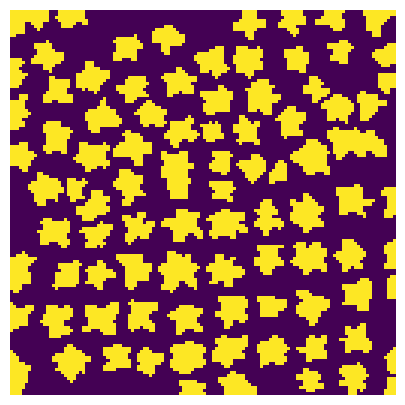

In [52]:
show(readimg(f"../data/satellite/masks/{image_id}.png").any(-1))

(np.float64(10.0), np.float64(810.0))

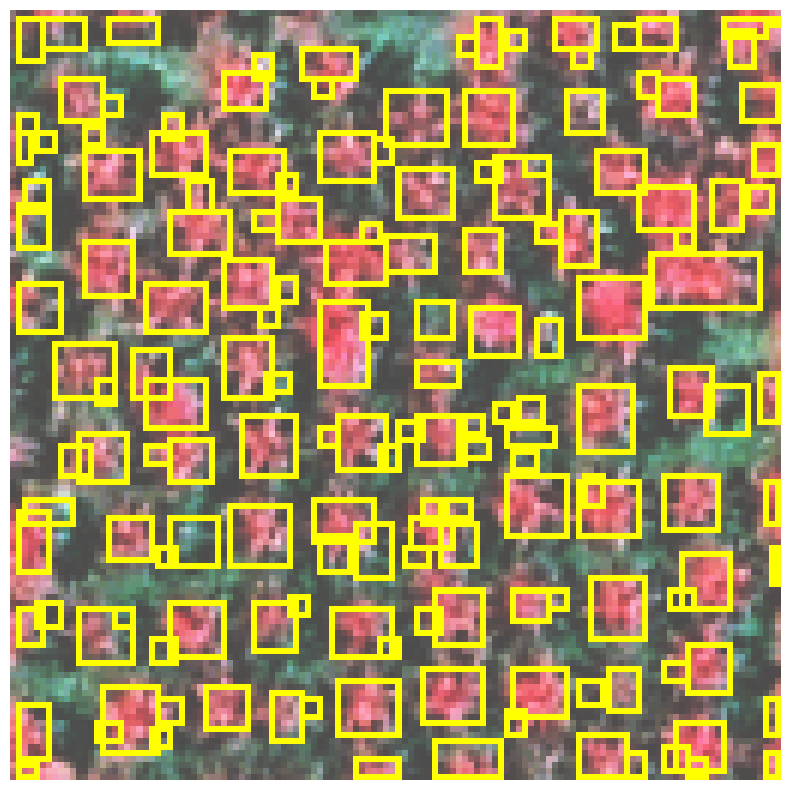

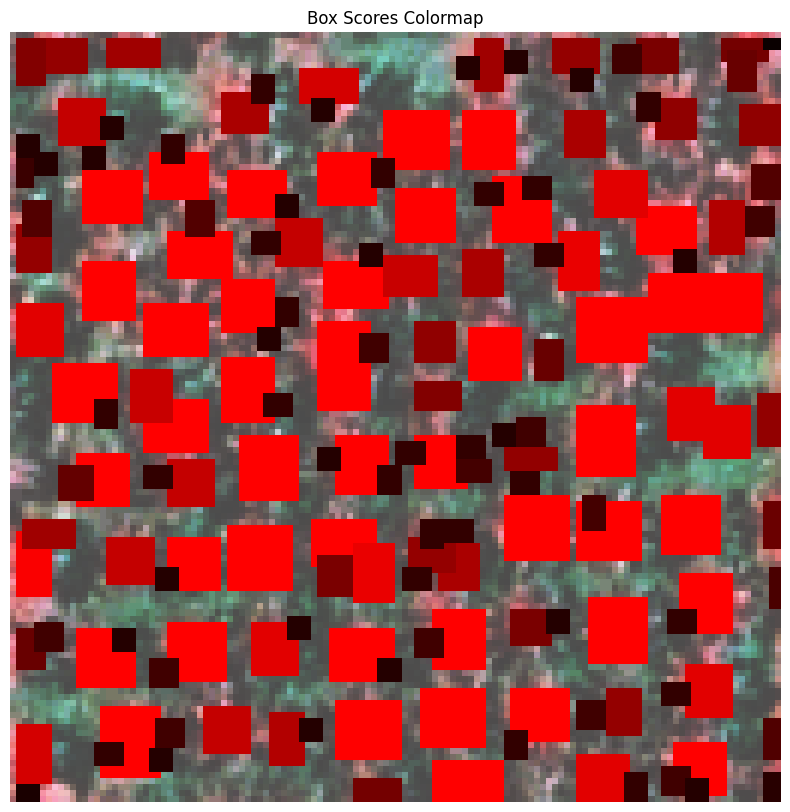

In [59]:
def calc_scores(boxes):
    h = boxes[:, 3] - boxes[:, 1]
    w = boxes[:, 2] - boxes[:, 0]

    # return ((w - h) / (w + h) + 1) / 2 *
    return (w - h) ** 2 + (w + h) ** 2

def threshold_scores(boxes, threshold: int = 100):
    scores = calc_scores(boxes)
    return (scores > threshold).astype(float) * 255

scr = calc_scores(boxes)

# scr = (scr > 100).astype(float) * 255

show(drawbox(image, boxes), figsize=(20, 10))
show(fillbox(image, boxes, scr), labels=["Box Scores Colormap"], figsize=(20, 10))
scr.min(), scr.max()

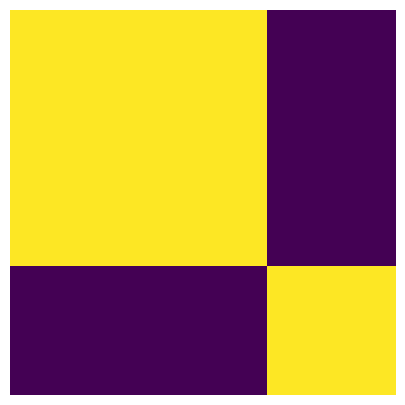

In [ ]:
def neighbours(boxes, offset=0):
    ln = len(boxes)
    ns = np.zeros((ln, ln))

    for i, b1 in enumerate(boxes):
        for j, b2 in enumerate(boxes[i:], start=i):
            b10, b12 = min(b1[0], b1[2]), max(b1[0], b1[2])
            b11, b13 = min(b1[1], b1[3]), max(b1[1], b1[3])

            b20, b22 = min(b2[0], b2[2]), max(b2[0], b2[2])
            b21, b23 = min(b2[1], b2[3]), max(b2[1], b2[3])

            if not (
                (b10 - offset <= b20 <= b12 + offset and (b11 - offset <= b21 <= b13 + offset or b11 - offset <= b23 <= b13 + offset)) or
                (b10 - offset <= b22 <= b12 + offset and (b11 - offset <= b21 <= b13 + offset or b11 - offset <= b23 <= b13 + offset)) or
                (b20 - offset <= b10 <= b22 + offset and (b21 - offset <= b11 <= b23 + offset or b21 - offset <= b13 <= b23 + offset)) or
                (b20 - offset <= b12 <= b22 + offset and (b21 - offset <= b11 <= b23 + offset or b21 - offset <= b13 <= b23 + offset))
            ):
                continue

            ns[i, j] = ns[j, i] = 1
    return ns

# nboxes = [[5, 5, 10, 10], [15, 5, 20, 10], [7, 7, 13, 20]]
nboxes = boxes[[67, 69, 0]]
show(neighbours(nboxes, 0))


In [ ]:

def find_connected_components(adj_matrix):
    visited = np.zeros(adj_matrix.shape[0], dtype=bool)
    components = []

    def dfs(node, component):
        visited[node] = True
        component.append(node)
        for neighbor, is_connected in enumerate(adj_matrix[node]):
            if is_connected and not visited[neighbor]:
                dfs(neighbor, component)

    for node in range(adj_matrix.shape[0]):
        if not visited[node]:
            component = []
            dfs(node, component)
            components.append(component)

    return components

connected_components = find_connected_components(sns)
print(f"Number of connected components: {len(connected_components)}")
print("Connected components:", connected_components)

NameError: name 'sns' is not defined

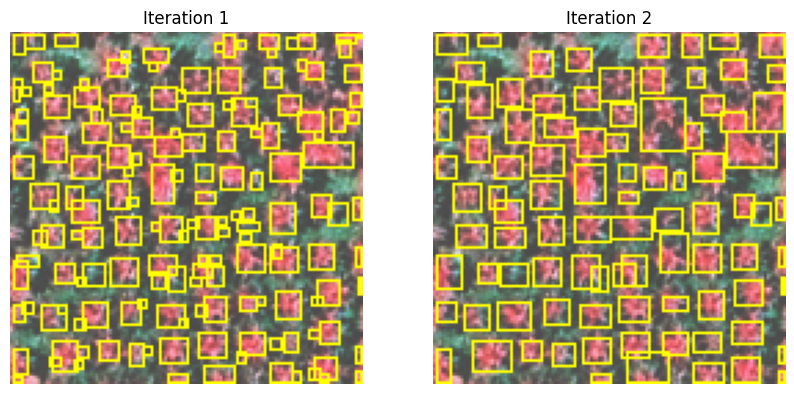

In [57]:
# neighbourhood graph

def collapse(boxes):
    return np.array([
        boxes[:, 0].min(), boxes[:, 1].min(),
        boxes[:, 2].max(), boxes[:, 3].max()
    ])

def task(boxes, score_threshold: int = 100, neighbour_threshold: int = 1):
    scr = threshold_scores(boxes, score_threshold)

    sns = neighbours(boxes, neighbour_threshold)
    vis = np.zeros(sns.shape[0])

    res = []

    scr0, = np.where(scr == 0)

    for i in scr0:
        where, = np.where(sns[i] != 0)
        where = where[where != i]

        if not where.size:
            continue

        max_box = where[max(enumerate(calc_scores(boxes[where])), key=lambda _: _[1])[0]]

        if 1 in vis[[max_box, i]]:
            continue

        vis[[max_box, i]] = 1
        res.append(collapse(boxes[[max_box, i]]))

    res.extend(boxes[vis == 0])
    return np.array(res)

def task_repeat(repeat, boxes, s_threshold: int = 180, n_threshold: int = 1):
    for i in range(repeat):
        boxes = task(boxes, s_threshold, n_threshold)

    return boxes

boxes2 = task_repeat(10, boxes, 180, 1)
show(drawbox(image, boxes), drawbox(image, boxes2), labels=["Iteration 1", "Iteration 2"])

In [43]:
from transformers import SamModel, SamProcessor

device = "mps"

m = SamModel.from_pretrained("facebook/sam-vit-large").to(device)
p = SamProcessor.from_pretrained("facebook/sam-vit-large")

In [44]:
sbx = boxes2.copy()
sbx[:, 0] -= 1
sbx[:, 1] -= 1
sbx[:, 2] += 1
sbx[:, 3] += 1

inps = p(
    images=[image],
    input_boxes=[sbx.astype(np.float32).tolist()],
    return_tensors="pt" )
inps["input_boxes"] = inps.input_boxes.to(torch.float32)

with torch.no_grad():
    out = m(**inps.to(device))

In [45]:
masks, = p.post_process_masks(out.pred_masks.detach().cpu(), inps.original_sizes.cpu(), inps.reshaped_input_sizes.cpu())
masks.shape

torch.Size([92, 3, 128, 128])

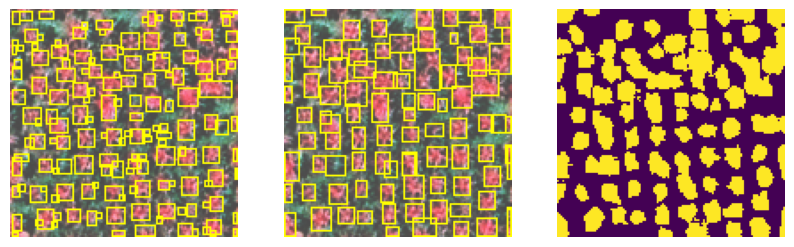

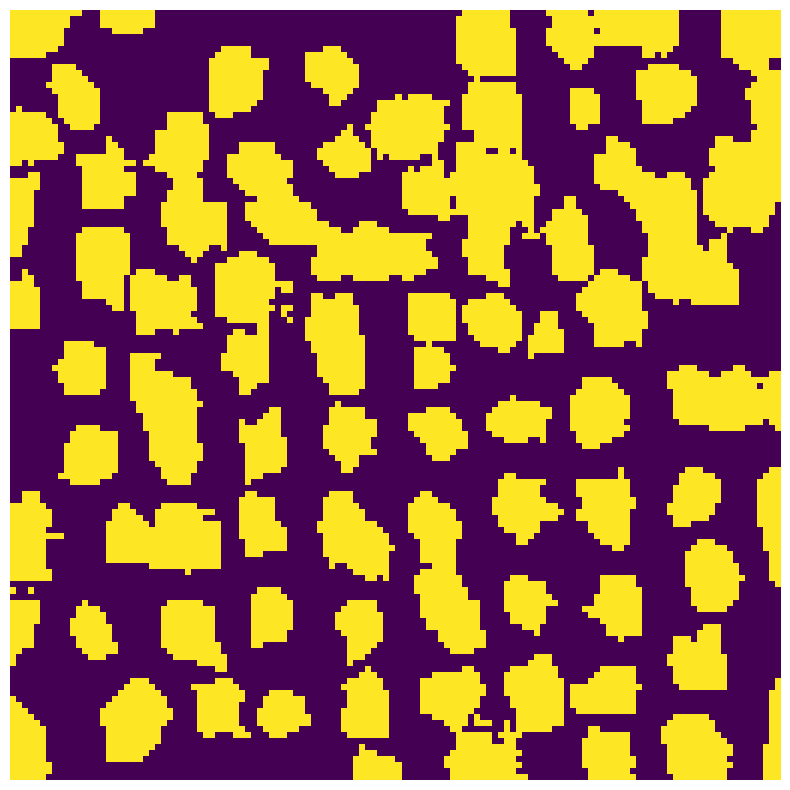

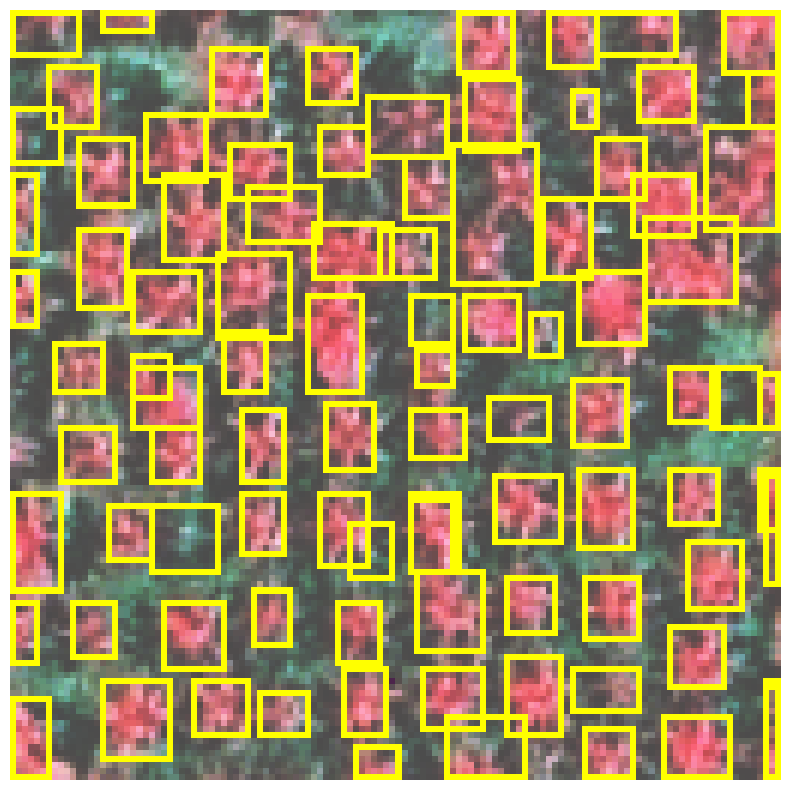

In [47]:

rboxes = []

for mask in masks.any(axis=1):
    ys, xs = np.where(mask)
    bx = np.array([xs.min(), ys.min(), xs.max(), ys.max()])
    rboxes.append(bx)

rboxes = np.array(rboxes)

show(drawbox(image, sboxes), drawbox(image, rboxes), masks.any(axis=1).any(axis=0))

show(masks.any(axis=1).any(axis=0), figsize=(20, 10))
show(drawbox(image, rboxes), figsize=(20, 10))